 # 1-step Forecasting with linear and non-linear models (Nomothetic)

In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn import linear_model as lm
from sklearn.model_selection import TimeSeriesSplit

import utils

# Plot settings
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['figure.dpi'] = 150
sns.set()

In [2]:
# Reading alcohol data
train_df, test_df, data_raw_list = utils.load_alcohol()

# Create one big dataset that contains the information of all participants, and split into dependent/independent features
# train_alcohol = pd.concat(train_df, ignore_index=True)
combined_data = []

for i in range(len(train_df)):
    train = train_df[i]
    test = test_df[i]
    # Combine both train and test sets since the initial split was 50/50
    combined = pd.concat([train, test])
    # Sort by date
    combined['start'] = pd.to_datetime(combined['start'])
    combined = combined.sort_values(by='start')
    combined_data.append(combined)

train_df_temporal = []
test_df_temporal = []
# average_train_size = []
# Create temporal 70/30 splits for alcohol dataset
for i in range(len(combined_data)):
    test_size = int(0.3 * len(combined_data[i]))
    # train_size = int(0.7 * len(combined_data[i]))
    # average_train_size.append(train_size)
    test_df_temporal.append(combined_data[i].iloc[-test_size:])
    train_df_temporal.append(combined_data[i].iloc[:-test_size])

train_alcohol = pd.concat(train_df_temporal, ignore_index=True)
train_alcohol_X = train_alcohol.drop(train_alcohol.columns[range(0, 61)], axis=1).fillna(0)
train_alcohol_y = train_alcohol['craving']


# print(np.mean(average_train_size))


# Function to split the test sets into dependent/independent features, since they are taken per individual
def prepare_data(idx, test_list):
    # print('Patient ID:', test_list[idx]['ID'][0])
    X_test = test_list[idx].drop(test_list[idx].columns[range(0, 61)], axis=1).fillna(0)
    y_test = test_list[idx]['craving']
    return X_test, y_test


In [3]:
# Loading train and test data of covid patients
covid_train_x_list, covid_test_x_list, covid_train_y_list, covid_test_y_list = utils.patients_covid()

find_avg_size = []
for i in range(len(covid_train_x_list)):
    find_avg_size.append(len(covid_train_x_list[i]))

print(np.mean(find_avg_size))
# Concatenate the train set for the global models
covid_train_X = pd.concat(covid_train_x_list, ignore_index=True)
covid_train_y = pd.concat(covid_train_y_list, ignore_index=True)

55
Patient included in study:
[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 14, 15, 16, 17, 21, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 46, 48, 49, 50, 52, 53, 54, 55, 58, 59, 63, 64, 65, 66, 68, 70, 71, 72, 74, 75, 77]
27.70909090909091


# 1. Nomothetic Models Regression

In [4]:


# Elastic-Net

def elastic_net(train_x, train_y):
    # Standardize variables (mean 0, std 1)
    X_train_loc = utils.standardize(train_x).fillna(0)

    # Train Elastic Net model with 5-fold cross-validation
    grid = {'alpha': np.arange(0.01, 10, 0.05),
            'l1_ratio': np.arange(0.01, 0.7, 0.05),
            'fit_intercept': [True],
            'max_iter': [10000]}
    # Train model with 5-fold cross-validation
    elastic_reg = GridSearchCV(estimator=lm.ElasticNet(), param_grid=grid, scoring='neg_mean_squared_error',
                               cv=TimeSeriesSplit(n_splits=5), n_jobs=5)
    elastic_reg.fit(X_train_loc, train_y)

    return elastic_reg


# Generate a model for both datasets, that will later be used for testing
print('--- Alcohol Data ---')
test_alcohol_X, test_alcohol_y = prepare_data(1, test_df_temporal)
elastic_alcohol = elastic_net(train_alcohol_X, train_alcohol_y)
print('Trained')
print('--- Covid Data ---')
elastic_covid = elastic_net(covid_train_X, covid_train_y)
print('Trained')

--- Alcohol Data ---
Trained
--- Covid Data ---
Trained


In [5]:
# Linear-SVM

def linear_svm(train_x, train_y, params):
    # Standardize
    X_train_loc = utils.standardize(train_x).fillna(0)

    # Train a SVM with a linear kernel, 5-fold cross validation, also optimizing the hyperparameters from the provided 'params' variable
    clf = GridSearchCV(estimator=LinearSVR(), param_grid=params, scoring='neg_mean_squared_error',
                       cv=TimeSeriesSplit(n_splits=5))
    clf.fit(X_train_loc, train_y)
    print(clf.best_params_)

    return clf


# Train model for the two datasets
print('--- Alcohol Data ---')
# Hyperparameter grid for 'Alcohol' dataset
param = [
    {'C': np.arange(0.1, 4, 0.1),
     'epsilon': np.arange(6, 7, 0.1),
     'loss': ['epsilon_insensitive'],
     'fit_intercept': [True],
     'max_iter': [10000]}]

svm_alcohol = linear_svm(train_alcohol_X, train_alcohol_y, param)
print('Trained')
print('--- Covid Data ---')
# Hyperparameter grid for COVID-19 dataset
param = [
    {'C': np.arange(0.1, 2, 0.1),
     'epsilon': np.arange(0, 0.5, 0.1),
     'loss': ['epsilon_insensitive'],
     'fit_intercept': [True],
     'max_iter': [10000]}]
svm_covid = linear_svm(covid_train_X, covid_train_y, param)
print('Trained')

--- Alcohol Data ---
{'C': 0.1, 'epsilon': 6.899999999999997, 'fit_intercept': True, 'loss': 'epsilon_insensitive', 'max_iter': 10000}
Trained
--- Covid Data ---


C:\Users\Alex\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Alex\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Alex\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Alex\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Alex\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 1.0, 'epsilon': 0.4, 'fit_intercept': True, 'loss': 'epsilon_insensitive', 'max_iter': 10000}
Trained


In [5]:
# XGBoost

def xgboost_reg(train_x, train_y):
    # Hyperparameter grid
    params = [
        {'objective': ['reg:squarederror'],
         'n_estimators': [10, 15, 20, 25, 30, 45, 60, 70],
         'booster': ['gbtree'],
         'eta': [0.05, 0.1, 0.2, 0.3],
         'alpha': np.arange(0, 1, 0.1),
         'colsample_bytree': [0.5, 0.75, 0.9, 1],
         'eval_metric': ['rmse'],
         'max_depth': np.arange(1, 8, 1)}]

    # Train a XGBoost model with 5-fold cross-validation
    reg_xgb = GridSearchCV(xgb.XGBRegressor(), params, cv=TimeSeriesSplit(n_splits=5), n_jobs=5,
                           scoring='neg_mean_squared_error')
    reg_xgb.fit(train_x, train_y)
    print(reg_xgb.best_params_)

    return reg_xgb


# Train model for both datasets
print('--- Alcohol Data ---')
xgb_alcohol = xgboost_reg(train_alcohol_X, train_alcohol_y)
print('Trained')
print('--- Covid Data ---')
xgb_covid = xgboost_reg(covid_train_X, covid_train_y)
print('Trained')

--- Alcohol Data ---
{'alpha': 0.0, 'booster': 'gbtree', 'colsample_bytree': 0.5, 'eta': 0.1, 'eval_metric': 'rmse', 'max_depth': 1, 'n_estimators': 60, 'objective': 'reg:squarederror'}
Trained
--- Covid Data ---
{'alpha': 0.8, 'booster': 'gbtree', 'colsample_bytree': 0.5, 'eta': 0.2, 'eval_metric': 'rmse', 'max_depth': 2, 'n_estimators': 25, 'objective': 'reg:squarederror'}
Trained


In [7]:
from sklearn.ensemble import RandomForestRegressor


# Random Forests

def random_forests(train_x, train_y):
    # Hyperparameter grid
    grid = [
        {'n_estimators': [50, 70, 85, 100, 120, 140],
         'max_features': ['auto', 'sqrt'],
         'max_depth': [3, 5, 10, 15, 20],
         'min_samples_split': [2, 4, 6],
         'min_samples_leaf': [1],
         'bootstrap': [True]}]

    # Random forests 5-fold cross-validation
    rf = GridSearchCV(RandomForestRegressor(), param_grid=grid, cv=TimeSeriesSplit(n_splits=5), n_jobs=5,
                      scoring='neg_mean_squared_error')
    rf.fit(train_x, train_y)
    print(rf.best_params_)
    # utils.eval_results(actual=test_y, predicted=y_predicted_test, show=True)

    return rf


# Train model for two datasets
print('--- Alcohol Data ---')
rf_alcohol = random_forests(train_alcohol_X, train_alcohol_y)
print('Trained')
print('--- Covid Data ---')
rf_covid = random_forests(covid_train_X, covid_train_y)
print('Trained')

--- Alcohol Data ---
{'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 140}
Trained
--- Covid Data ---
{'bootstrap': True, 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Trained


In [26]:
import keras.layers as layer
from keras.models import Sequential


# LSTM 3-Layer - Recurrent Neural Network

def lstm_rnn(train_x, train_y, batch):
    # Standardize data and then transform to a suitable input
    X_train_loc = utils.standardize(train_x).fillna(0)
    train_x_val, train_y_val = X_train_loc.values, train_y.values

    train_x_val = train_x_val.reshape((train_x_val.shape[0], 1, train_x_val.shape[1]))

    # Neural network architecture
    model = Sequential([
        layer.Input(shape=(train_x_val.shape[1], train_x_val.shape[2])),
        layer.LSTM(40, return_sequences=True),
        layer.Dropout(0.25),
        layer.LSTM(units=25, return_sequences=True),
        layer.Dropout(0.20),
        layer.LSTM(units=10, return_sequences=False),
        layer.Dense(units=1, activation='linear')
    ])

    # Compile model using the mean absolute error loss function and the adam optimizer
    model.compile(loss='mae', optimizer='adam')
    # Train for 40 epochs
    model.fit(train_x_val, train_y_val, epochs=50, batch_size=batch, verbose=0, shuffle=False)

    return model


# Train a model for two datasets
print('--- Alcohol Data ---')
lstm_alcohol = lstm_rnn(train_alcohol_X, train_alcohol_y, 62)
print('Trained')
print('--- Covid Data ---')
lstm_covid = lstm_rnn(covid_train_X, covid_train_y, 28)
print('Trained')

--- Alcohol Data ---
Trained
--- Covid Data ---
Trained


In [34]:
# LSTM 1-Layer - Recurrent Neural Network

def one_lstm_rnn(train_x, train_y, batch):
    # Standardize then transform to suitable input
    X_train_loc = utils.standardize(train_x).fillna(0)
    train_x_val, train_y_val = X_train_loc.values, train_y.values

    train_x_val = train_x_val.reshape((train_x_val.shape[0], 1, train_x_val.shape[1]))

    # Neural network architecture
    model = Sequential([
        layer.Input(shape=(train_x_val.shape[1], train_x_val.shape[2])),
        layer.Bidirectional(layer.LSTM(32, return_sequences=True)),
        layer.Dropout(0.25),
        layer.Dense(units=1, activation='linear')
    ])

    # Compile and train model as the 3-Layer one
    model.compile(loss='mae', optimizer='adam')
    model.fit(train_x_val, train_y_val, epochs=50, batch_size=batch, verbose=0, shuffle=False)

    return model


print('--- Alcohol Data ---')
lstm1_alcohol = one_lstm_rnn(train_alcohol_X, train_alcohol_y, 62)
print('Trained')
print('--- Covid Data ---')
lstm1_covid = one_lstm_rnn(covid_train_X, covid_train_y, 28)
print('Trained')

--- Alcohol Data ---
Trained
--- Covid Data ---
Trained


In [28]:
# Gated Recurrent Unit - Recurrent Neural Network

def gru_rnn(train_x, train_y, batch):
    # Standardize and transform to suitable input
    X_train_loc = utils.standardize(train_x).fillna(0)
    train_x_val, train_y_val = X_train_loc.values, train_y.values

    train_x_val = train_x_val.reshape((train_x_val.shape[0], 1, train_x_val.shape[1]))

    # Neural network architecture
    model = Sequential([
        layer.Input(shape=(train_x_val.shape[1], train_x_val.shape[2])),
        layer.GRU(64, return_sequences=True),
        layer.Dropout(0.25),
        layer.GRU(units=32, return_sequences=True),
        layer.Dropout(0.20),
        layer.GRU(units=16, return_sequences=False),
        layer.Dense(units=1, activation='linear')
    ])
    # Compile and train model
    model.compile(loss='mae', optimizer='adam')
    model.fit(train_x_val, train_y_val, epochs=50, batch_size=batch, verbose=0, shuffle=False)

    return model


# Train a GRU model for two datasets
print('--- Alcohol Data ---')
gru_alcohol = gru_rnn(train_alcohol_X, train_alcohol_y, 62)
print('Trained')
print('--- Covid Data ---')
gru_covid = gru_rnn(covid_train_X, covid_train_y, 28)
print('Trained')

--- Alcohol Data ---
Trained
--- Covid Data ---
Trained


### 2. Evaluating Performance on Entire Dataset (Alcohol)

In [38]:
# Lists to hold the metrics for all patients and models
mse_elastic, mse_svm, mse_one_lstm, mse_xgb, mse_rf, mse_lstm, mse_gru = ([] for _ in range(7))
rmse_elastic, rmse_svm, rmse_one_lstm, rmse_xgb, rmse_rf, rmse_lstm, rmse_gru = ([] for _ in range(7))
mae_elastic, mae_svm, mae_one_lstm, mae_xgb, mae_rf, mae_lstm, mae_gru = ([] for _ in range(7))

# Write results to text file
f = open("output_nomothethic_a.txt", "a")
f.write('- - - PER INDIVIDUAL RESULTS GLOBAL MODELS - - -\n')

for x in range(len(test_df_temporal)):
    # Build and evaluate a model for every single patient

    test_alcohol_X, test_alcohol_y = prepare_data(x, test_df_temporal)
    # Elastic-Net (baseline)
    mse, rmse, mae = utils.eval_results(test_alcohol_y,
                                        elastic_alcohol.predict(utils.standardize(test_alcohol_X).fillna(0)), False)

    # Elastic-Net metrics
    mse_elastic.append(mse)
    rmse_elastic.append(rmse)
    mae_elastic.append(mae)

    f.write("Patient ID: %s\n" % train_df_temporal[x]['ID'][0])
    f.write('\n')
    f.write('--- Elastic-Net ---\n')
    f.write("MSE: %s\n" % mse)
    f.write("RMSE: %s\n" % rmse)
    f.write("MAE: %s\n" % mae)
    f.write('\n')

    # Linear-SVM

    params = [
        {'C': np.arange(0.1, 4, 0.1),
         'epsilon': np.arange(6, 7, 0.1),
         'loss': ['epsilon_insensitive'],
         'fit_intercept': [True],
         'max_iter': [10000]}]

    mse, rmse, mae = utils.eval_results(test_alcohol_y,
                                        svm_alcohol.predict(utils.standardize(test_alcohol_X).fillna(0)),
                                        False)
    # Linear-SVM metrics
    mse_svm.append(mse)
    rmse_svm.append(rmse)
    mae_svm.append(mae)

    f.write('--- Linear-SVM ---\n')
    f.write("MSE: %s\n" % mse)
    f.write("RMSE: %s\n" % rmse)
    f.write("MAE: %s\n" % mae)
    f.write('\n')

    # XGBoost Regression
    mse, rmse, mae = utils.eval_results(test_alcohol_y, xgb_alcohol.predict(test_alcohol_X), False)
    # XGBoost metrics
    mse_xgb.append(mse)
    rmse_xgb.append(rmse)
    mae_xgb.append(mae)

    f.write('--- XGBoost ---\n')
    f.write("MSE: %s\n" % mse)
    f.write("RMSE: %s\n" % rmse)
    f.write("MAE: %s\n" % mae)
    f.write('\n')

    # RF
    mse, rmse, mae = utils.eval_results(test_alcohol_y, rf_alcohol.predict(test_alcohol_X), False)
    # RF metrics
    mse_rf.append(mse)
    rmse_rf.append(rmse)
    mae_rf.append(mae)

    f.write('--- Random Forests ---\n')
    f.write("MSE: %s\n" % mse)
    f.write("RMSE: %s\n" % rmse)
    f.write("MAE: %s\n" % mae)
    f.write('\n')

    # LSTM 3-Layer RNN
    test_x_val = utils.standardize(test_alcohol_X).fillna(0).values
    test_x_val = test_x_val.reshape((test_x_val.shape[0], 1, test_x_val.shape[1]))
    mse, rmse, mae = utils.eval_results(test_alcohol_y, lstm_alcohol.predict(
        test_x_val).flatten(), False)
    # LSTM metrics
    mse_lstm.append(mse)
    rmse_lstm.append(rmse)
    mae_lstm.append(mae)

    f.write('--- LSTM RNN ---\n')
    f.write("MSE: %s\n" % mse)
    f.write("RMSE: %s\n" % rmse)
    f.write("MAE: %s\n" % mae)
    f.write('\n')

    # LSTM 1-Layer RNN
    mse, rmse, mae = utils.eval_results(test_alcohol_y, lstm1_alcohol.predict(
        test_x_val).flatten(), False)
    # LSTM metrics
    mse_one_lstm.append(mse)
    rmse_one_lstm.append(rmse)
    mae_one_lstm.append(mae)

    f.write('--- 1-LSTM RNN ---\n')
    f.write("MSE: %s\n" % mse)
    f.write("RMSE: %s\n" % rmse)
    f.write("MAE: %s\n" % mae)
    f.write('\n')

    # GRU RNN

    mse, rmse, mae = utils.eval_results(test_alcohol_y, gru_alcohol.predict(test_x_val).flatten(), False)

    # GRU metrics
    mse_gru.append(mse)
    rmse_gru.append(rmse)
    mae_gru.append(mae)

    f.write('--- GRU RNN ---\n')
    f.write("MSE: %s\n" % mse)
    f.write("RMSE: %s\n" % rmse)
    f.write("MAE: %s\n" % mae)
    f.write('\n')

f.close()
# Compute average metrics for all models
print('---- Elastic-Net Results ----')
utils.average_metrics(mse_elastic, rmse_elastic, mae_elastic)
print('---------------------------------')
print('---- Linear SVM Results ----')
utils.average_metrics(mse_svm, rmse_svm, mae_svm)
print('---------------------------------')
print('---- XGBoost Results ----')
utils.average_metrics(mse_xgb, rmse_xgb, mae_xgb)
print('---------------------------------')
print('---- Random Forest Results ----')
utils.average_metrics(mse_rf, rmse_rf, mae_rf)
print('---------------------------------')
print('---- LSTM Results ----')
utils.average_metrics(mse_lstm, rmse_lstm, mae_lstm)
print('---------------------------------')
print('---- 1-LSTM Results ----')
utils.average_metrics(mse_one_lstm, rmse_one_lstm, mae_one_lstm)
print('---------------------------------')
print('---- GRU Results ----')
utils.average_metrics(mse_gru, rmse_gru, mae_gru)
print('---------------------------------')

rmse_overall = rmse_elastic + rmse_svm + rmse_xgb + rmse_rf + rmse_lstm + rmse_one_lstm + rmse_gru
n = len(rmse_rf)
model_names = ['Elastic Net'] * n + ['SVM'] * n + ['XGBoost'] * n + ['RF'] * n + ['3-Layer LSTM'] * n + [
    '1-Layer LSTM'] * n + ['GRU'] * n
dataset = ['Alcohol'] * len(model_names)
mae_overall = mae_elastic + mae_svm + mae_xgb + mae_rf + mae_lstm + mae_one_lstm + mae_gru

---- Elastic-Net Results ----
Average MSE: 248.55665138826313
Average RMSE: 13.789890049316858
Average MAE: 10.47749800715789
---------------------------------
---- Linear SVM Results ----
Average MSE: 258.10530364589226
Average RMSE: 14.236035640629932
Average MAE: 10.637055084484222
---------------------------------
---- XGBoost Results ----
Average MSE: 218.24395561408704
Average RMSE: 12.742873685978413
Average MAE: 9.672941360215196
---------------------------------
---- Random Forest Results ----
Average MSE: 243.13243306569376
Average RMSE: 14.098945517473581
Average MAE: 11.848224248903025
---------------------------------
---- LSTM Results ----
Average MSE: 277.246684295099
Average RMSE: 14.297539319857592
Average MAE: 10.532474728168761
---------------------------------
---- 1-LSTM Results ----
Average MSE: 314.3895007090686
Average RMSE: 14.828420888268809
Average MAE: 10.821390304276596
---------------------------------
---- GRU Results ----
Average MSE: 285.6483545971732
A

### 2.1 Evaluating Performance on Entire Dataset (COVID-19)

In [39]:
# Lists to hold the metrics for all patients and models
mse_elastic, mse_svm, mse_one_lstm, mse_xgb, mse_rf, mse_lstm, mse_gru = ([] for _ in range(7))
rmse_elastic, rmse_svm, rmse_one_lstm, rmse_xgb, rmse_rf, rmse_lstm, rmse_gru = ([] for _ in range(7))
mae_elastic, mae_svm, mae_one_lstm, mae_xgb, mae_rf, mae_lstm, mae_gru = ([] for _ in range(7))

# Write results to text file
f = open("output_nomothethic_c.txt", "a")
f.write('- - - PER INDIVIDUAL RESULTS GLOBAL MODELS - - -\n')

for z in range(len(covid_train_x_list)):
    # Build and evaluate a model for every single patient

    # Elastic-Net (baseline)
    mse, rmse, mae = utils.eval_results(covid_test_y_list[z],
                                        elastic_covid.predict(utils.standardize(covid_test_x_list[z]).fillna(0)),
                                        False)

    # Elastic-Net metrics
    mse_elastic.append(mse)
    rmse_elastic.append(rmse)
    mae_elastic.append(mae)

    f.write("Patient ID: %s\n" % z)
    f.write('\n')
    f.write('--- Elastic-Net ---\n')
    f.write("MSE: %s\n" % mse)
    f.write("RMSE: %s\n" % rmse)
    f.write("MAE: %s\n" % mae)
    f.write('\n')

    # Linear-SVM

    params = [
        {'C': np.arange(0.1, 2, 0.1),
         'epsilon': np.arange(0, 0.5, 0.1),
         'loss': ['epsilon_insensitive'],
         'fit_intercept': [True],
         'max_iter': [10000]}]

    mse, rmse, mae = utils.eval_results(covid_test_y_list[z],
                                        svm_covid.predict(utils.standardize(covid_test_x_list[z]).fillna(0)),
                                        False)
    # Linear-SVM metrics
    mse_svm.append(mse)
    rmse_svm.append(rmse)
    mae_svm.append(mae)

    f.write('--- Linear-SVM ---\n')
    f.write("MSE: %s\n" % mse)
    f.write("RMSE: %s\n" % rmse)
    f.write("MAE: %s\n" % mae)
    f.write('\n')

    # XGBoost Regression
    mse, rmse, mae = utils.eval_results(covid_test_y_list[z], xgb_covid.predict(covid_test_x_list[z]), False)
    # XGBoost metrics
    mse_xgb.append(mse)
    rmse_xgb.append(rmse)
    mae_xgb.append(mae)

    f.write('--- XGBoost ---\n')
    f.write("MSE: %s\n" % mse)
    f.write("RMSE: %s\n" % rmse)
    f.write("MAE: %s\n" % mae)
    f.write('\n')

    # RF
    mse, rmse, mae = utils.eval_results(covid_test_y_list[z], rf_covid.predict(covid_test_x_list[z]), False)
    # RF metrics
    mse_rf.append(mse)
    rmse_rf.append(rmse)
    mae_rf.append(mae)

    f.write('--- Random Forests ---\n')
    f.write("MSE: %s\n" % mse)
    f.write("RMSE: %s\n" % rmse)
    f.write("MAE: %s\n" % mae)
    f.write('\n')

    # LSTM 3-Layer RNN
    test_x_val = utils.standardize(covid_test_x_list[z]).fillna(0).values
    test_x_val = test_x_val.reshape((test_x_val.shape[0], 1, test_x_val.shape[1]))
    mse, rmse, mae = utils.eval_results(covid_test_y_list[z], lstm_covid.predict(
        test_x_val).flatten(), False)
    # LSTM metrics
    mse_lstm.append(mse)
    rmse_lstm.append(rmse)
    mae_lstm.append(mae)

    f.write('--- LSTM RNN ---\n')
    f.write("MSE: %s\n" % mse)
    f.write("RMSE: %s\n" % rmse)
    f.write("MAE: %s\n" % mae)
    f.write('\n')

    # LSTM 1-Layer RNN
    mse, rmse, mae = utils.eval_results(covid_test_y_list[z], lstm1_covid.predict(
        test_x_val).flatten(), False)
    # LSTM metrics
    mse_one_lstm.append(mse)
    rmse_one_lstm.append(rmse)
    mae_one_lstm.append(mae)

    f.write('--- 1-LSTM RNN ---\n')
    f.write("MSE: %s\n" % mse)
    f.write("RMSE: %s\n" % rmse)
    f.write("MAE: %s\n" % mae)
    f.write('\n')

    # GRU RNN
    mse, rmse, mae = utils.eval_results(covid_test_y_list[z], gru_covid.predict(test_x_val).flatten(), False)

    # GRU metrics
    mse_gru.append(mse)
    rmse_gru.append(rmse)
    mae_gru.append(mae)

    f.write('--- GRU RNN ---\n')
    f.write("MSE: %s\n" % mse)
    f.write("RMSE: %s\n" % rmse)
    f.write("MAE: %s\n" % mae)
    f.write('\n')

f.close()
# Compute average metrics for all models
print('---- Elastic-Net Results ----')
utils.average_metrics(mse_elastic, rmse_elastic, mae_elastic)
print('---------------------------------')
print('---- Linear SVM Results ----')
utils.average_metrics(mse_svm, rmse_svm, mae_svm)
print('---------------------------------')
print('---- XGBoost Results ----')
utils.average_metrics(mse_xgb, rmse_xgb, mae_xgb)
print('---------------------------------')
print('---- Random Forest Results ----')
utils.average_metrics(mse_rf, rmse_rf, mae_rf)
print('---------------------------------')
print('---- LSTM Results ----')
utils.average_metrics(mse_lstm, rmse_lstm, mae_lstm)
print('---------------------------------')
print('---- 1-LSTM Results ----')
utils.average_metrics(mse_one_lstm, rmse_one_lstm, mae_one_lstm)
print('---------------------------------')
print('---- GRU Results ----')
utils.average_metrics(mse_gru, rmse_gru, mae_gru)
print('---------------------------------')

rmse_overall_covid = rmse_elastic + rmse_svm + rmse_xgb + rmse_rf + rmse_lstm + rmse_one_lstm + rmse_gru
n = len(rmse_rf)
model_names_covid = ['Elastic Net'] * n + ['SVM'] * n + ['XGBoost'] * n + ['RF'] * n + ['3-Layer LSTM'] * n + [
    '1-Layer LSTM'] * n + ['GRU'] * n
dataset_covid = ['COVID-19'] * len(model_names_covid)
mae_overall_covid = mae_elastic + mae_svm + mae_xgb + mae_rf + mae_lstm + mae_one_lstm + mae_gru

---- Elastic-Net Results ----
Average MSE: 0.863263694951668
Average RMSE: 0.8575623196555632
Average MAE: 0.7392624336326966
---------------------------------
---- Linear SVM Results ----
Average MSE: 0.8999565279146319
Average RMSE: 0.881570227130652
Average MAE: 0.7526124682780715
---------------------------------
---- XGBoost Results ----
Average MSE: 0.4635160551953458
Average RMSE: 0.6389233791006909
Average MAE: 0.5350302536526987
---------------------------------
---- Random Forest Results ----
Average MSE: 0.46562782686562587
Average RMSE: 0.6399499052670403
Average MAE: 0.5247539680263373
---------------------------------
---- LSTM Results ----
Average MSE: 0.853738324949657
Average RMSE: 0.8589883238439234
Average MAE: 0.7347658374735913
---------------------------------
---- 1-LSTM Results ----
Average MSE: 0.7537390503659853
Average RMSE: 0.7831099744064833
Average MAE: 0.6602776127719789
---------------------------------
---- GRU Results ----
Average MSE: 0.84846769454160

In [37]:
# Write results to csv

mae = mae_overall + mae_overall_covid
rmse = rmse_overall + rmse_overall_covid
models = model_names + model_names_covid
dataset_names = dataset + dataset_covid

dictionary = {'MAE': mae, 'RMSE': rmse, 'Model': models, 'Dataset': dataset_names}
df = pd.DataFrame(data=dictionary)

df.to_csv('nomothetic.csv')

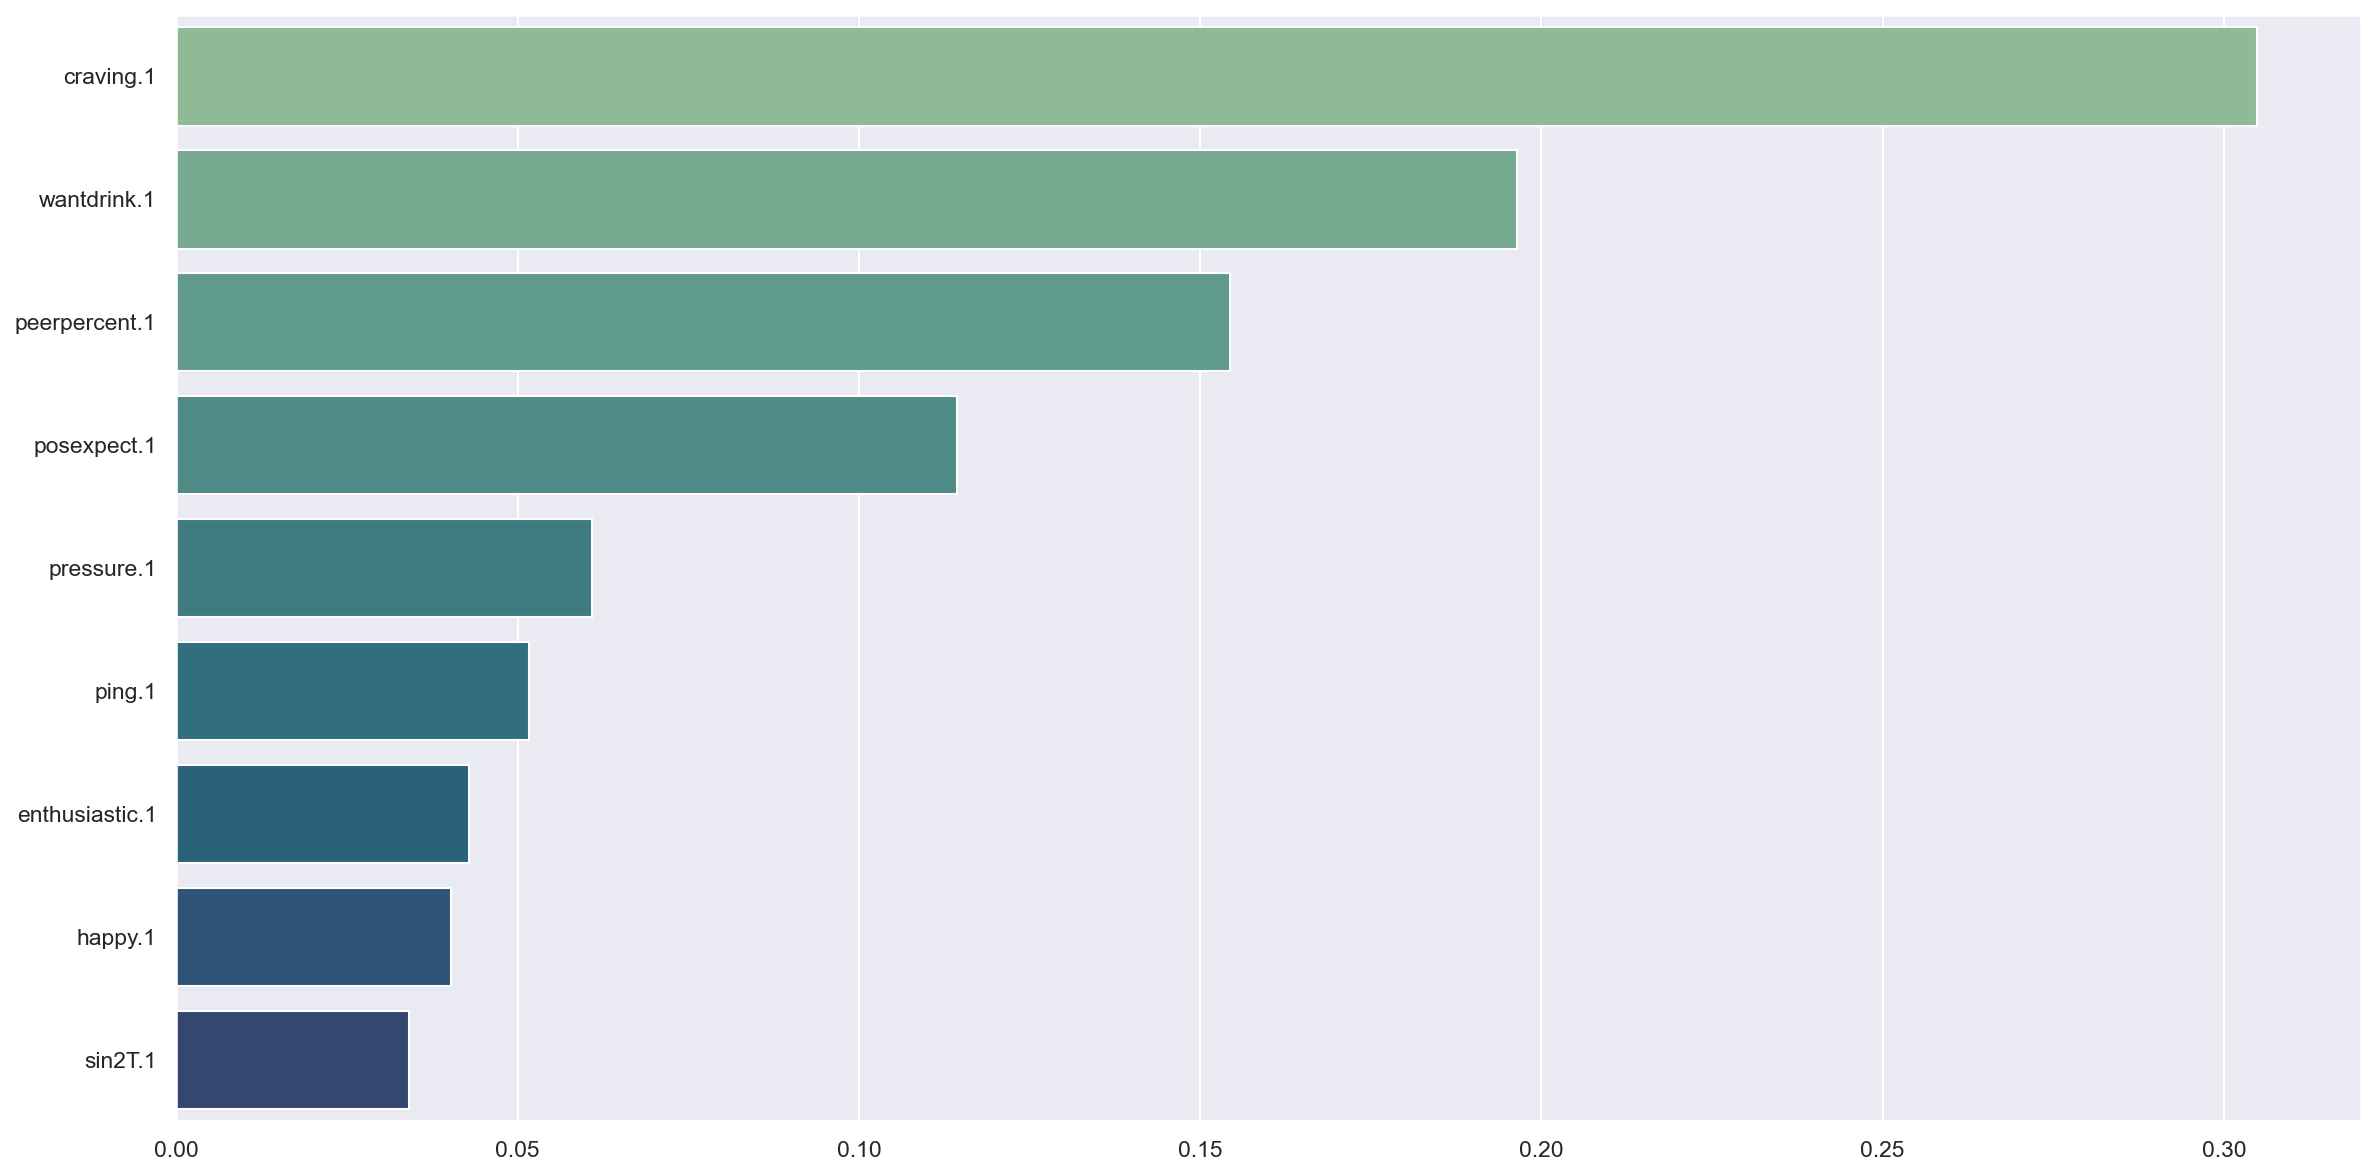

In [52]:
# Feature Importance

# Find the best features from XGBoost
best_features = xgb_alcohol.best_estimator_.feature_importances_
sort_by_index = best_features.argsort()[::-1]

# Plot the features by importance
features_plot = sns.barplot(x=best_features[sort_by_index][:9], y=train_alcohol_X.columns[sort_by_index][:9], palette = "crest")
# plt.xlabel('Feature Importance')
# lt.ylabel('Feature Name')
# plt.title('Feature Importance as found by XGBoost for Alcohol dataset')
plt.tight_layout()
plt.show()

features_plot.figure.savefig('xgb_alcohol.png')

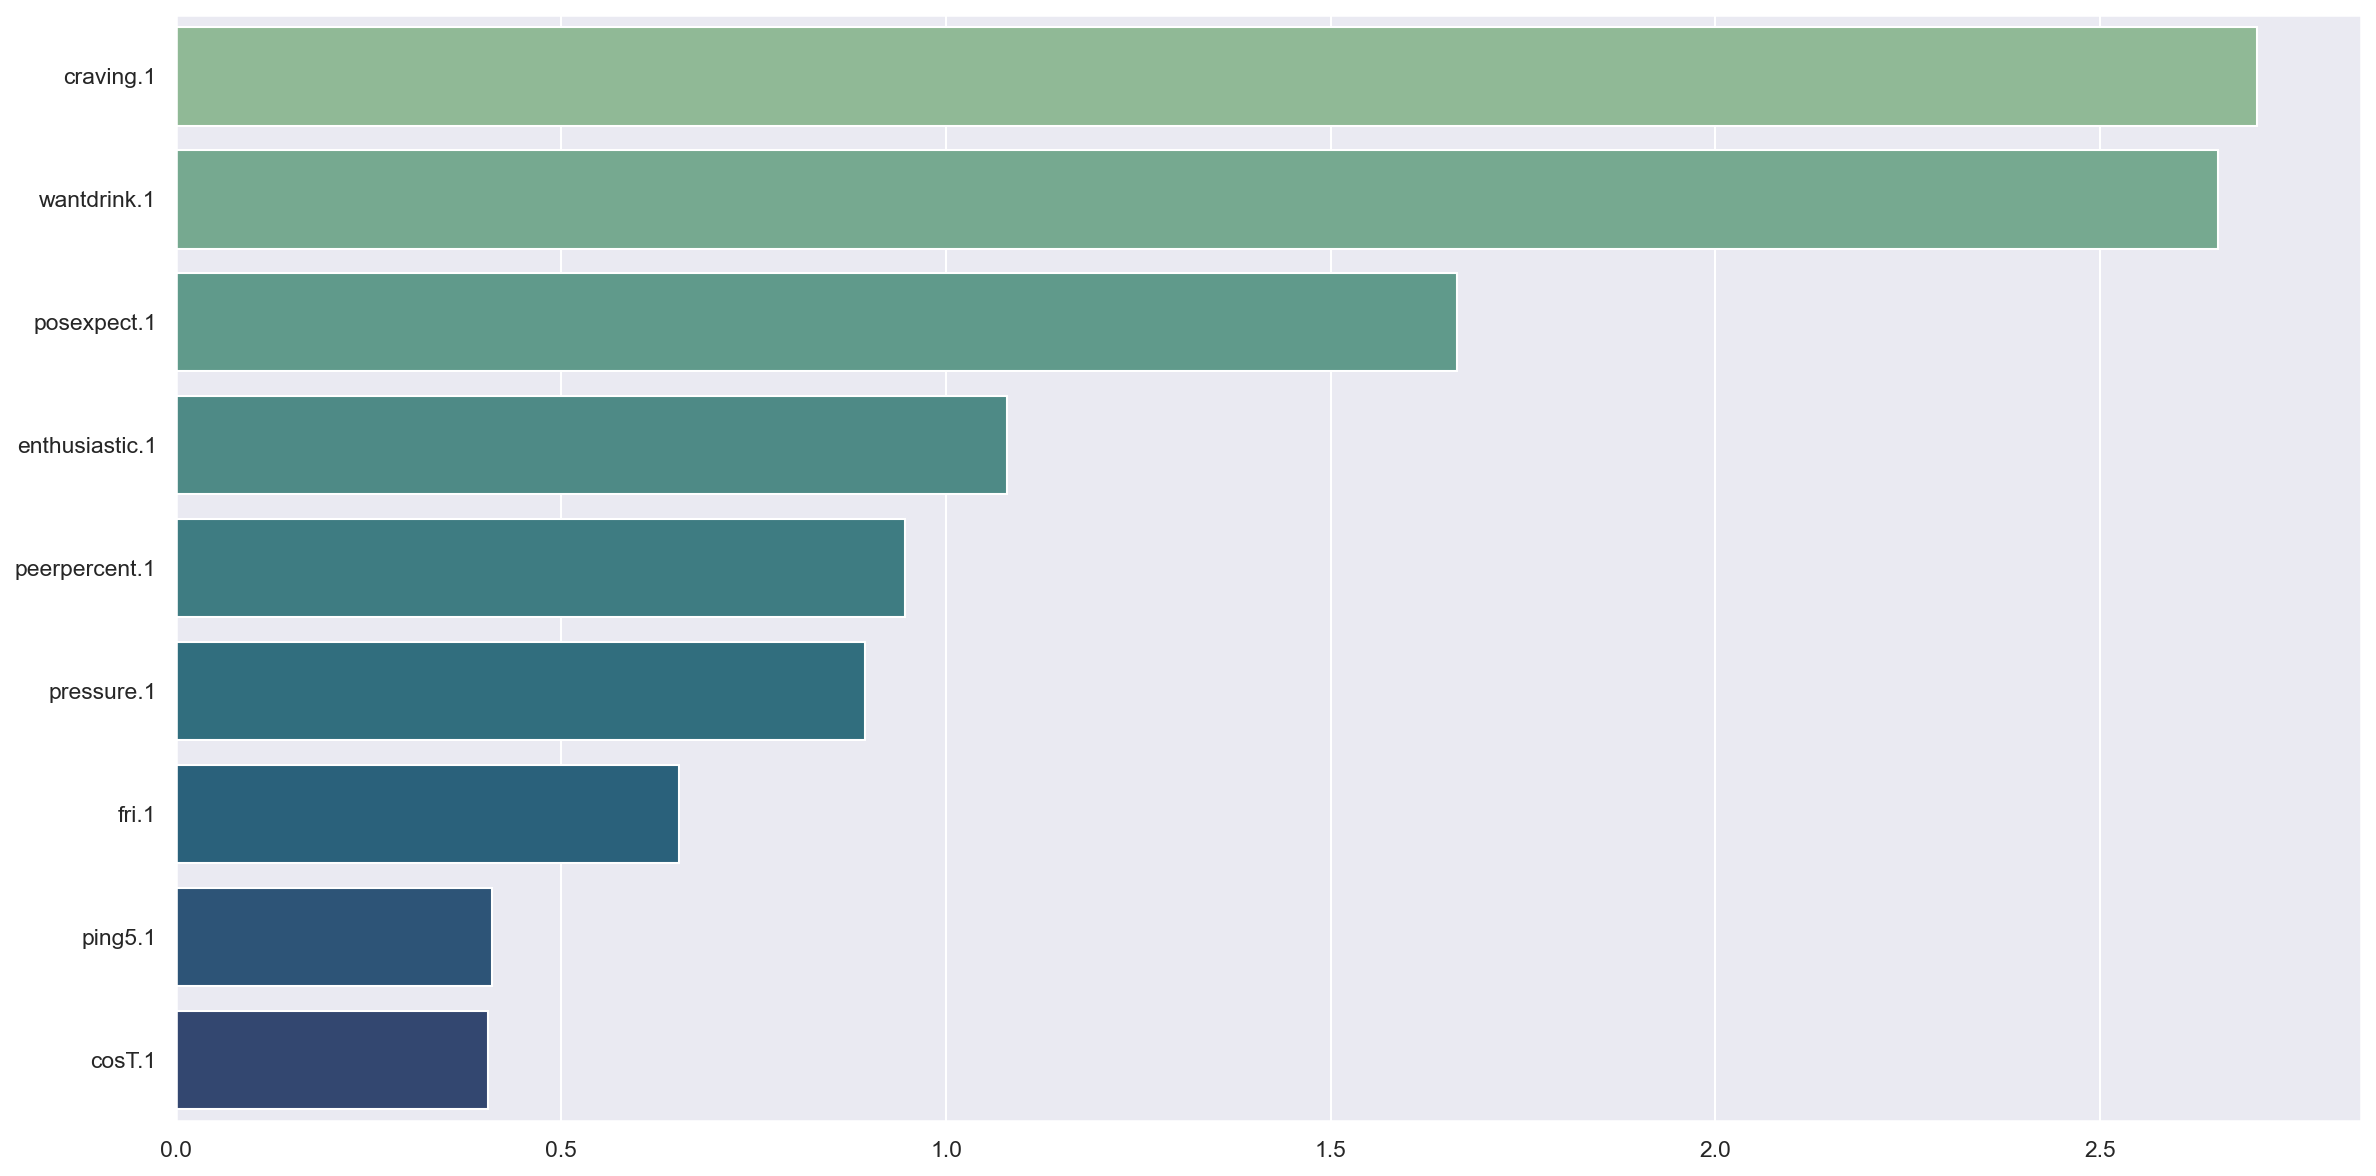

In [54]:
# Find the best features from Elastic Net
best_features = elastic_alcohol.best_estimator_.coef_
sort_by_index = best_features.argsort()[::-1]

# Plot the features by importance
features_plot = sns.barplot(x=best_features[sort_by_index][:9], y=train_alcohol_X.columns[sort_by_index][:9], palette = "crest")
#plt.xlabel('Feature Importance')
#plt.ylabel('Feature Name')
#plt.title('Feature Importance as found by Elastic Net for Alcohol dataset')
plt.tight_layout()
plt.show()
features_plot.figure.savefig('elastic_alcohol.png')

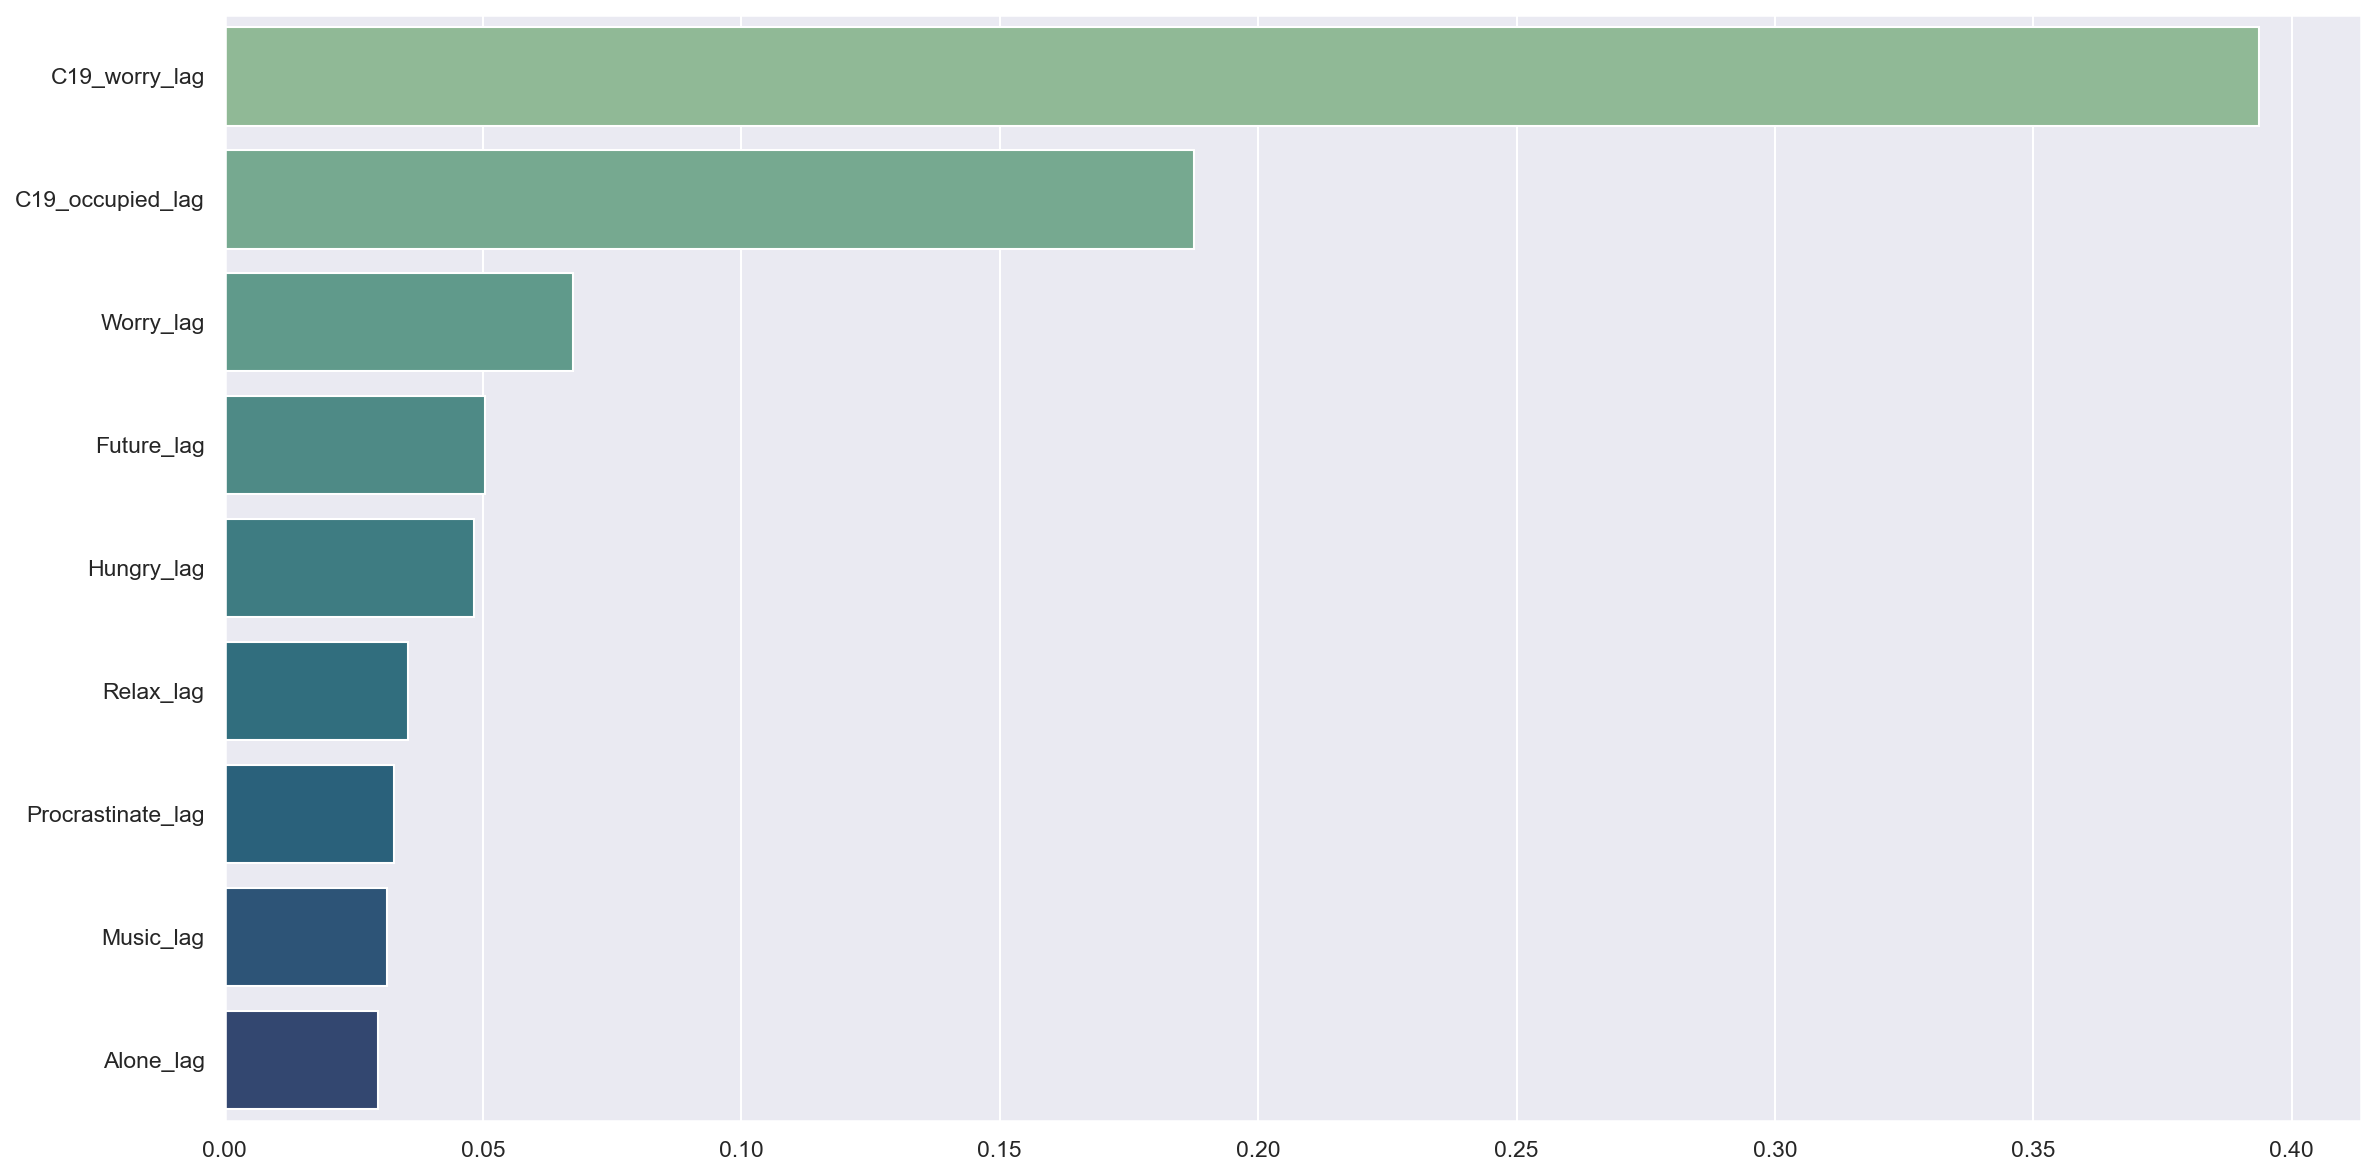

In [57]:
# Find the best features from XGBoost
best_features = xgb_covid.best_estimator_.feature_importances_
sort_by_index = best_features.argsort()[::-1]

# Plot the features by importance
features_plot = sns.barplot(x=best_features[sort_by_index][:9], y=covid_train_x_list[0].columns[sort_by_index][:9], palette = "crest")
#plt.xlabel('Feature Importance')
#plt.ylabel('Feature Name')
#plt.title('Feature Importance as found by XGBoost for COVID-19 dataset')
plt.tight_layout()
plt.show()
features_plot.figure.savefig('xgb_covid.png')

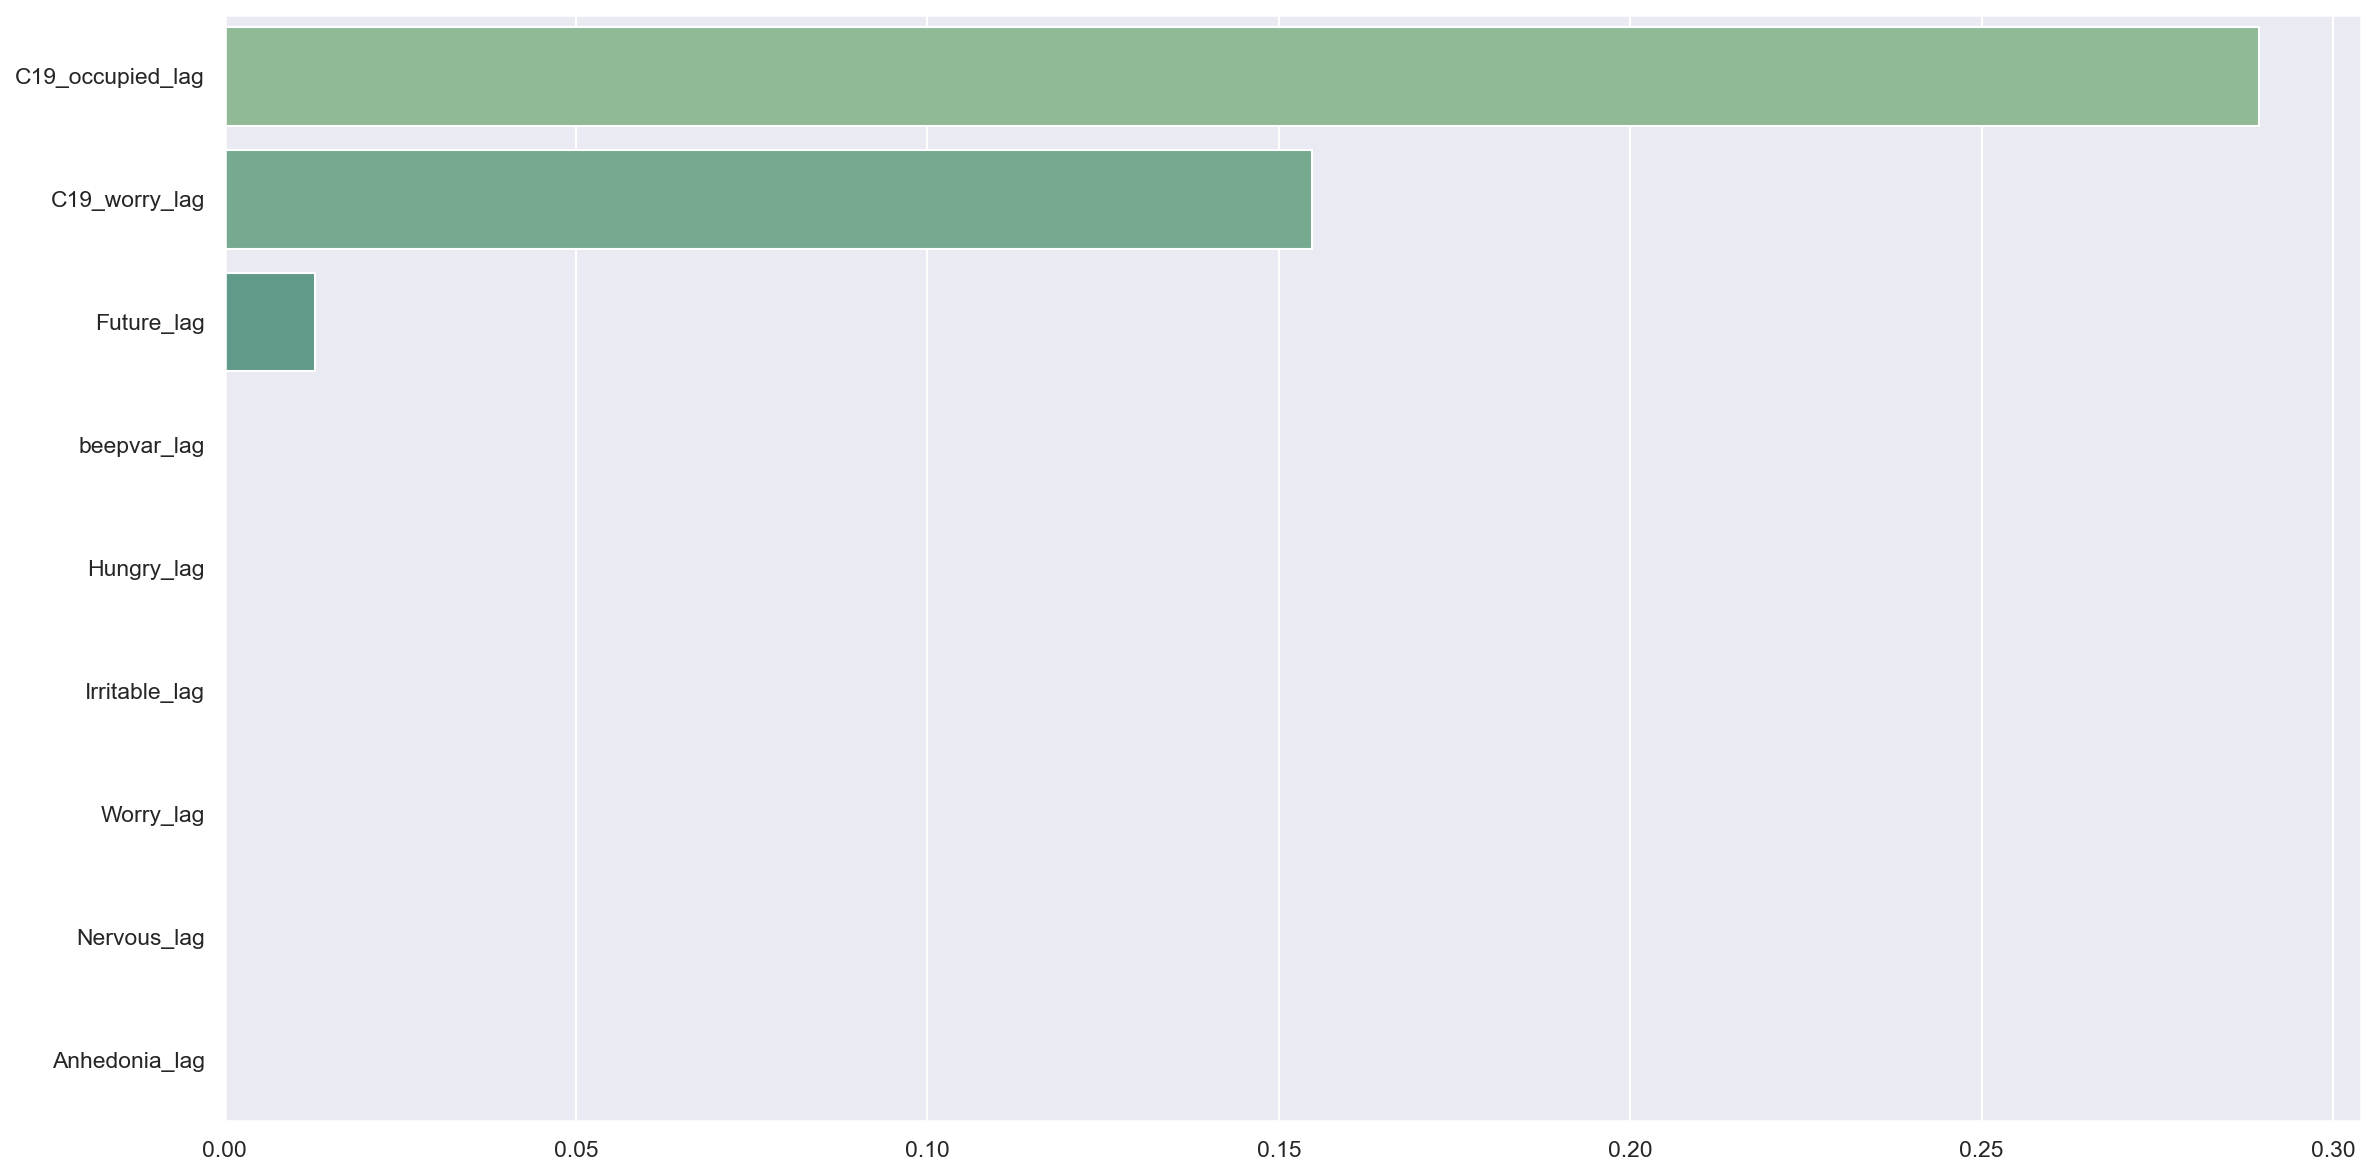

In [58]:
# Find the best features from Elastic Net
best_features = elastic_covid.best_estimator_.coef_
sort_by_index = best_features.argsort()[::-1]

# Plot the features by importance
features_plot = sns.barplot(x=best_features[sort_by_index][:9], y=covid_train_x_list[0].columns[sort_by_index][:9], palette = "crest")
#plt.xlabel('Feature Importance')
#plt.ylabel('Feature Name')
#plt.title('Feature Importance as found by Elastic Net for COVID-19 dataset')
plt.tight_layout()
plt.show()
features_plot.figure.savefig('elastic_covid.png')